In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from tqdm import tqdm
import random

In [2]:
x_train_paths = []
y_train_paths = []
x_val_paths = []
y_val_paths = []

all_paths = []
all_labels = []
data_dir = 'dataset/'
for label in os.listdir(data_dir):
    for image in os.listdir(data_dir+label):
        all_paths.append(data_dir+label+'/'+image)
        all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)

x_train_paths = all_paths[:5000]
y_train = all_labels[:5000]
x_val_paths = all_paths[5000:]
y_val = all_labels[5000:]

In [3]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
    image = np.array(image)/255.0
    return image

In [4]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

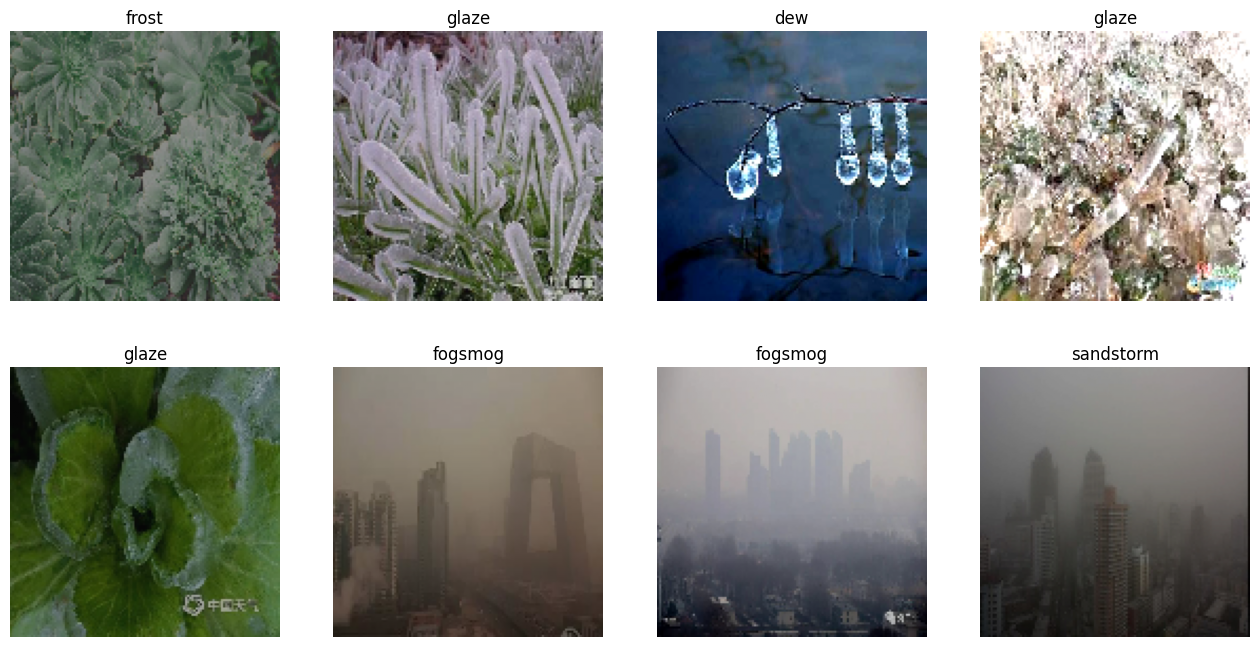

In [5]:
num_images = 9
images = open_images(x_train_paths[:num_images])
fig = plt.figure(figsize=(16, round(num_images/4)*4))
for x in range(1, num_images):
    fig.add_subplot(int(num_images/4), 4, x)
    plt.axis('off')
    plt.title(y_train[x])
    plt.imshow(images[x])
plt.show()

In [6]:
unique_labels = os.listdir('dataset/')
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

In [7]:
def data_gen(paths, labels, batch_size=12):
    
    if len(paths)!=len(labels):
        raise Exception('The length of paths is ',len(paths), ' but the length of labels is ', len(labels))
    
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths)
        batch_labels = labels[x:x+batch_size]
        batch_labels = encode_label(batch_labels)
        yield batch_images, batch_labels

In [8]:
vgg16 = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in vgg16.layers:
    layer.trainable = False

In [9]:
model = Sequential()
model.add(Input(shape=(128,128,3)))
model.add(vgg16)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 768)               6292224   
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
batch_size=12
steps = int(len(x_train_paths)/batch_size)
epochs=1 
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

416/416 [==============================] - 197s 472ms/step - loss: 1.5619 - accuracy: 0.4587


In [12]:
batch_size=12
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

1/1 [==============================] - 1s 539ms/step


  1%|▌                                                                                 | 1/155 [00:00<01:55,  1.33it/s]

1/1 [==============================] - 0s 416ms/step


  1%|█                                                                                 | 2/155 [00:01<01:39,  1.53it/s]

1/1 [==============================] - 0s 401ms/step


  2%|█▌                                                                                | 3/155 [00:01<01:34,  1.61it/s]

1/1 [==============================] - 0s 410ms/step


  3%|██                                                                                | 4/155 [00:02<01:31,  1.65it/s]

1/1 [==============================] - 0s 400ms/step


  3%|██▋                                                                               | 5/155 [00:03<01:28,  1.70it/s]

1/1 [==============================] - 0s 400ms/step


  4%|███▏                                                                              | 6/155 [00:03<01:29,  1.66it/s]

1/1 [==============================] - 0s 413ms/step


  5%|███▋                                                                              | 7/155 [00:04<01:28,  1.68it/s]

1/1 [==============================] - 0s 411ms/step


  5%|████▏                                                                             | 8/155 [00:04<01:28,  1.66it/s]

1/1 [==============================] - 0s 402ms/step


  6%|████▊                                                                             | 9/155 [00:05<01:26,  1.68it/s]

1/1 [==============================] - 0s 408ms/step


  6%|█████▏                                                                           | 10/155 [00:06<01:25,  1.69it/s]

1/1 [==============================] - 0s 410ms/step


  7%|█████▋                                                                           | 11/155 [00:06<01:25,  1.69it/s]

1/1 [==============================] - 0s 425ms/step


  8%|██████▎                                                                          | 12/155 [00:07<01:25,  1.68it/s]

1/1 [==============================] - 0s 401ms/step


  8%|██████▊                                                                          | 13/155 [00:07<01:25,  1.67it/s]

1/1 [==============================] - 0s 406ms/step


  9%|███████▎                                                                         | 14/155 [00:08<01:24,  1.66it/s]

1/1 [==============================] - 0s 416ms/step


 10%|███████▊                                                                         | 15/155 [00:09<01:23,  1.69it/s]

1/1 [==============================] - 0s 412ms/step


 10%|████████▎                                                                        | 16/155 [00:09<01:22,  1.69it/s]

1/1 [==============================] - 0s 408ms/step


 11%|████████▉                                                                        | 17/155 [00:10<01:22,  1.68it/s]

1/1 [==============================] - 0s 392ms/step


 12%|█████████▍                                                                       | 18/155 [00:10<01:20,  1.70it/s]

1/1 [==============================] - 0s 424ms/step


 12%|█████████▉                                                                       | 19/155 [00:11<01:20,  1.70it/s]

1/1 [==============================] - 0s 404ms/step


 13%|██████████▍                                                                      | 20/155 [00:11<01:18,  1.72it/s]

1/1 [==============================] - 0s 425ms/step


 14%|██████████▉                                                                      | 21/155 [00:12<01:18,  1.70it/s]

1/1 [==============================] - 0s 401ms/step


 14%|███████████▍                                                                     | 22/155 [00:13<01:17,  1.71it/s]

1/1 [==============================] - 0s 401ms/step


 15%|████████████                                                                     | 23/155 [00:13<01:17,  1.70it/s]

1/1 [==============================] - 0s 479ms/step


 15%|████████████▌                                                                    | 24/155 [00:14<01:21,  1.61it/s]

1/1 [==============================] - 0s 425ms/step


 16%|█████████████                                                                    | 25/155 [00:15<01:21,  1.60it/s]

1/1 [==============================] - 0s 448ms/step


 17%|█████████████▌                                                                   | 26/155 [00:15<01:22,  1.57it/s]

1/1 [==============================] - 0s 470ms/step


 17%|██████████████                                                                   | 27/155 [00:16<01:22,  1.56it/s]

1/1 [==============================] - 0s 457ms/step


 18%|██████████████▋                                                                  | 28/155 [00:17<01:21,  1.55it/s]

1/1 [==============================] - 0s 417ms/step


 19%|███████████████▏                                                                 | 29/155 [00:17<01:23,  1.51it/s]

1/1 [==============================] - 0s 420ms/step


 19%|███████████████▋                                                                 | 30/155 [00:18<01:19,  1.56it/s]

1/1 [==============================] - 0s 396ms/step


 20%|████████████████▏                                                                | 31/155 [00:18<01:17,  1.60it/s]

1/1 [==============================] - 0s 409ms/step


 21%|████████████████▋                                                                | 32/155 [00:19<01:16,  1.62it/s]

1/1 [==============================] - 0s 466ms/step


 21%|█████████████████▏                                                               | 33/155 [00:20<01:18,  1.56it/s]

1/1 [==============================] - 0s 473ms/step


 22%|█████████████████▊                                                               | 34/155 [00:20<01:18,  1.55it/s]

1/1 [==============================] - 0s 438ms/step


 23%|██████████████████▎                                                              | 35/155 [00:21<01:18,  1.53it/s]

1/1 [==============================] - 0s 427ms/step


 23%|██████████████████▊                                                              | 36/155 [00:22<01:15,  1.57it/s]

1/1 [==============================] - 0s 405ms/step


 24%|███████████████████▎                                                             | 37/155 [00:22<01:14,  1.59it/s]

1/1 [==============================] - 0s 451ms/step


 25%|███████████████████▊                                                             | 38/155 [00:23<01:14,  1.58it/s]

1/1 [==============================] - 0s 412ms/step


 25%|████████████████████▍                                                            | 39/155 [00:23<01:12,  1.60it/s]

1/1 [==============================] - 0s 419ms/step


 26%|████████████████████▉                                                            | 40/155 [00:24<01:11,  1.61it/s]

1/1 [==============================] - 0s 401ms/step


 26%|█████████████████████▍                                                           | 41/155 [00:25<01:09,  1.65it/s]

1/1 [==============================] - 0s 416ms/step


 27%|█████████████████████▉                                                           | 42/155 [00:25<01:09,  1.64it/s]

1/1 [==============================] - 0s 422ms/step


 28%|██████████████████████▍                                                          | 43/155 [00:26<01:07,  1.65it/s]

1/1 [==============================] - 0s 411ms/step


 28%|██████████████████████▉                                                          | 44/155 [00:27<01:07,  1.65it/s]

1/1 [==============================] - 0s 443ms/step


 29%|███████████████████████▌                                                         | 45/155 [00:27<01:07,  1.62it/s]

1/1 [==============================] - 0s 432ms/step


 30%|████████████████████████                                                         | 46/155 [00:28<01:07,  1.62it/s]

1/1 [==============================] - 0s 431ms/step


 30%|████████████████████████▌                                                        | 47/155 [00:28<01:07,  1.60it/s]

1/1 [==============================] - 0s 418ms/step


 31%|█████████████████████████                                                        | 48/155 [00:29<01:06,  1.60it/s]

1/1 [==============================] - 0s 424ms/step


 32%|█████████████████████████▌                                                       | 49/155 [00:30<01:05,  1.61it/s]

1/1 [==============================] - 0s 432ms/step


 32%|██████████████████████████▏                                                      | 50/155 [00:30<01:05,  1.61it/s]

1/1 [==============================] - 0s 418ms/step


 33%|██████████████████████████▋                                                      | 51/155 [00:31<01:03,  1.63it/s]

1/1 [==============================] - 0s 427ms/step


 34%|███████████████████████████▏                                                     | 52/155 [00:31<01:03,  1.62it/s]

1/1 [==============================] - 0s 395ms/step


 34%|███████████████████████████▋                                                     | 53/155 [00:32<01:01,  1.66it/s]

1/1 [==============================] - 0s 392ms/step


 35%|████████████████████████████▏                                                    | 54/155 [00:33<00:59,  1.68it/s]

1/1 [==============================] - 0s 416ms/step


 35%|████████████████████████████▋                                                    | 55/155 [00:33<00:59,  1.68it/s]

1/1 [==============================] - 0s 407ms/step


 36%|█████████████████████████████▎                                                   | 56/155 [00:34<00:58,  1.69it/s]

1/1 [==============================] - 0s 408ms/step


 37%|█████████████████████████████▊                                                   | 57/155 [00:34<00:57,  1.70it/s]

1/1 [==============================] - 0s 403ms/step


 37%|██████████████████████████████▎                                                  | 58/155 [00:35<00:56,  1.71it/s]

1/1 [==============================] - 0s 402ms/step


 38%|██████████████████████████████▊                                                  | 59/155 [00:36<00:56,  1.71it/s]

1/1 [==============================] - 0s 409ms/step


 39%|███████████████████████████████▎                                                 | 60/155 [00:36<00:55,  1.71it/s]

1/1 [==============================] - 0s 401ms/step


 39%|███████████████████████████████▉                                                 | 61/155 [00:37<00:54,  1.73it/s]

1/1 [==============================] - 0s 421ms/step


 40%|████████████████████████████████▍                                                | 62/155 [00:37<00:54,  1.71it/s]

1/1 [==============================] - 0s 410ms/step


 41%|████████████████████████████████▉                                                | 63/155 [00:38<00:54,  1.70it/s]

1/1 [==============================] - 0s 409ms/step


 41%|█████████████████████████████████▍                                               | 64/155 [00:38<00:53,  1.69it/s]

1/1 [==============================] - 0s 421ms/step


 42%|█████████████████████████████████▉                                               | 65/155 [00:39<00:52,  1.71it/s]

1/1 [==============================] - 0s 404ms/step


 43%|██████████████████████████████████▍                                              | 66/155 [00:40<00:51,  1.72it/s]

1/1 [==============================] - 0s 404ms/step


 43%|███████████████████████████████████                                              | 67/155 [00:40<00:50,  1.73it/s]

1/1 [==============================] - 0s 404ms/step


 44%|███████████████████████████████████▌                                             | 68/155 [00:41<00:50,  1.72it/s]

1/1 [==============================] - 0s 408ms/step


 45%|████████████████████████████████████                                             | 69/155 [00:41<00:49,  1.72it/s]

1/1 [==============================] - 0s 410ms/step


 45%|████████████████████████████████████▌                                            | 70/155 [00:42<00:49,  1.71it/s]

1/1 [==============================] - 0s 394ms/step


 46%|█████████████████████████████████████                                            | 71/155 [00:43<00:48,  1.72it/s]

1/1 [==============================] - 0s 406ms/step


 46%|█████████████████████████████████████▋                                           | 72/155 [00:43<00:48,  1.70it/s]

1/1 [==============================] - 0s 416ms/step


 47%|██████████████████████████████████████▏                                          | 73/155 [00:44<00:48,  1.68it/s]

1/1 [==============================] - 0s 416ms/step


 48%|██████████████████████████████████████▋                                          | 74/155 [00:44<00:48,  1.69it/s]

1/1 [==============================] - 0s 412ms/step


 48%|███████████████████████████████████████▏                                         | 75/155 [00:45<00:47,  1.70it/s]

1/1 [==============================] - 0s 405ms/step


 49%|███████████████████████████████████████▋                                         | 76/155 [00:46<00:46,  1.69it/s]

1/1 [==============================] - 0s 410ms/step


 50%|████████████████████████████████████████▏                                        | 77/155 [00:46<00:46,  1.68it/s]

1/1 [==============================] - 0s 400ms/step


 50%|████████████████████████████████████████▊                                        | 78/155 [00:47<00:45,  1.69it/s]

1/1 [==============================] - 0s 417ms/step


 51%|█████████████████████████████████████████▎                                       | 79/155 [00:47<00:44,  1.70it/s]

1/1 [==============================] - 0s 414ms/step


 52%|█████████████████████████████████████████▊                                       | 80/155 [00:48<00:43,  1.71it/s]

1/1 [==============================] - 0s 416ms/step


 52%|██████████████████████████████████████████▎                                      | 81/155 [00:48<00:43,  1.71it/s]

1/1 [==============================] - 0s 401ms/step


 53%|██████████████████████████████████████████▊                                      | 82/155 [00:49<00:42,  1.72it/s]

1/1 [==============================] - 0s 413ms/step


 54%|███████████████████████████████████████████▎                                     | 83/155 [00:50<00:41,  1.71it/s]

1/1 [==============================] - 0s 417ms/step


 54%|███████████████████████████████████████████▉                                     | 84/155 [00:50<00:41,  1.73it/s]

1/1 [==============================] - 0s 412ms/step


 55%|████████████████████████████████████████████▍                                    | 85/155 [00:51<00:40,  1.72it/s]

1/1 [==============================] - 0s 416ms/step


 55%|████████████████████████████████████████████▉                                    | 86/155 [00:51<00:41,  1.67it/s]

1/1 [==============================] - 0s 404ms/step


 56%|█████████████████████████████████████████████▍                                   | 87/155 [00:52<00:40,  1.69it/s]

1/1 [==============================] - 0s 416ms/step


 57%|█████████████████████████████████████████████▉                                   | 88/155 [00:53<00:39,  1.68it/s]

1/1 [==============================] - 0s 400ms/step


 57%|██████████████████████████████████████████████▌                                  | 89/155 [00:53<00:39,  1.69it/s]

1/1 [==============================] - 0s 400ms/step


 58%|███████████████████████████████████████████████                                  | 90/155 [00:54<00:38,  1.70it/s]

1/1 [==============================] - 0s 439ms/step


 59%|███████████████████████████████████████████████▌                                 | 91/155 [00:54<00:37,  1.69it/s]

1/1 [==============================] - 0s 419ms/step


 59%|████████████████████████████████████████████████                                 | 92/155 [00:55<00:38,  1.65it/s]

1/1 [==============================] - 0s 419ms/step


 60%|████████████████████████████████████████████████▌                                | 93/155 [00:56<00:38,  1.62it/s]

1/1 [==============================] - 0s 432ms/step


 61%|█████████████████████████████████████████████████                                | 94/155 [00:56<00:37,  1.64it/s]

1/1 [==============================] - 0s 414ms/step


 61%|█████████████████████████████████████████████████▋                               | 95/155 [00:57<00:36,  1.64it/s]

1/1 [==============================] - 0s 422ms/step


 62%|██████████████████████████████████████████████████▏                              | 96/155 [00:57<00:35,  1.65it/s]

1/1 [==============================] - 0s 416ms/step


 63%|██████████████████████████████████████████████████▋                              | 97/155 [00:58<00:35,  1.65it/s]

1/1 [==============================] - 0s 411ms/step


 63%|███████████████████████████████████████████████████▏                             | 98/155 [00:59<00:34,  1.67it/s]

1/1 [==============================] - 0s 385ms/step


 64%|███████████████████████████████████████████████████▋                             | 99/155 [00:59<00:33,  1.68it/s]

1/1 [==============================] - 0s 413ms/step


 65%|███████████████████████████████████████████████████▌                            | 100/155 [01:00<00:32,  1.70it/s]

1/1 [==============================] - 0s 417ms/step


 65%|████████████████████████████████████████████████████▏                           | 101/155 [01:00<00:32,  1.68it/s]

1/1 [==============================] - 0s 417ms/step


 66%|████████████████████████████████████████████████████▋                           | 102/155 [01:01<00:30,  1.71it/s]

1/1 [==============================] - 0s 393ms/step


 66%|█████████████████████████████████████████████████████▏                          | 103/155 [01:02<00:30,  1.73it/s]

1/1 [==============================] - 0s 441ms/step


 67%|█████████████████████████████████████████████████████▋                          | 104/155 [01:02<00:30,  1.69it/s]

1/1 [==============================] - 0s 415ms/step


 68%|██████████████████████████████████████████████████████▏                         | 105/155 [01:03<00:29,  1.69it/s]

1/1 [==============================] - 0s 418ms/step


 68%|██████████████████████████████████████████████████████▋                         | 106/155 [01:03<00:29,  1.69it/s]

1/1 [==============================] - 0s 414ms/step


 69%|███████████████████████████████████████████████████████▏                        | 107/155 [01:04<00:28,  1.67it/s]

1/1 [==============================] - 0s 496ms/step


 70%|███████████████████████████████████████████████████████▋                        | 108/155 [01:05<00:28,  1.62it/s]

1/1 [==============================] - 0s 455ms/step


 70%|████████████████████████████████████████████████████████▎                       | 109/155 [01:05<00:28,  1.59it/s]

1/1 [==============================] - 0s 423ms/step


 71%|████████████████████████████████████████████████████████▊                       | 110/155 [01:06<00:28,  1.60it/s]

1/1 [==============================] - 0s 408ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 111/155 [01:07<00:27,  1.58it/s]

1/1 [==============================] - 0s 436ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 112/155 [01:07<00:26,  1.60it/s]

1/1 [==============================] - 0s 457ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 113/155 [01:08<00:26,  1.58it/s]

1/1 [==============================] - 0s 417ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 114/155 [01:08<00:25,  1.58it/s]

1/1 [==============================] - 0s 426ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 115/155 [01:09<00:24,  1.62it/s]

1/1 [==============================] - 0s 408ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 116/155 [01:10<00:23,  1.66it/s]

1/1 [==============================] - 0s 408ms/step


 75%|████████████████████████████████████████████████████████████▍                   | 117/155 [01:10<00:22,  1.67it/s]

1/1 [==============================] - 0s 416ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 118/155 [01:11<00:21,  1.69it/s]

1/1 [==============================] - 0s 412ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 119/155 [01:11<00:21,  1.69it/s]

1/1 [==============================] - 0s 395ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 120/155 [01:12<00:20,  1.71it/s]

1/1 [==============================] - 0s 417ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 121/155 [01:12<00:19,  1.70it/s]

1/1 [==============================] - 0s 395ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 122/155 [01:13<00:19,  1.66it/s]

1/1 [==============================] - 0s 397ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 123/155 [01:14<00:19,  1.67it/s]

1/1 [==============================] - 0s 451ms/step


 80%|████████████████████████████████████████████████████████████████                | 124/155 [01:14<00:18,  1.66it/s]

1/1 [==============================] - 0s 393ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 125/155 [01:15<00:17,  1.68it/s]

1/1 [==============================] - 0s 414ms/step


 81%|█████████████████████████████████████████████████████████████████               | 126/155 [01:16<00:17,  1.67it/s]

1/1 [==============================] - 0s 423ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 127/155 [01:16<00:16,  1.66it/s]

1/1 [==============================] - 0s 459ms/step


 83%|██████████████████████████████████████████████████████████████████              | 128/155 [01:17<00:16,  1.64it/s]

1/1 [==============================] - 0s 421ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 129/155 [01:17<00:16,  1.60it/s]

1/1 [==============================] - 0s 444ms/step


 84%|███████████████████████████████████████████████████████████████████             | 130/155 [01:18<00:15,  1.58it/s]

1/1 [==============================] - 0s 427ms/step


 85%|███████████████████████████████████████████████████████████████████▌            | 131/155 [01:19<00:15,  1.58it/s]

1/1 [==============================] - 1s 539ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 132/155 [01:19<00:15,  1.47it/s]

1/1 [==============================] - 0s 474ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 133/155 [01:20<00:15,  1.46it/s]

1/1 [==============================] - 0s 453ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 134/155 [01:21<00:13,  1.51it/s]

1/1 [==============================] - 0s 496ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 135/155 [01:21<00:13,  1.48it/s]

1/1 [==============================] - 0s 404ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 136/155 [01:22<00:12,  1.53it/s]

1/1 [==============================] - 0s 428ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 137/155 [01:23<00:11,  1.55it/s]

1/1 [==============================] - 0s 418ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 138/155 [01:23<00:10,  1.59it/s]

1/1 [==============================] - 0s 423ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 139/155 [01:24<00:10,  1.58it/s]

1/1 [==============================] - 0s 412ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 140/155 [01:25<00:09,  1.61it/s]

1/1 [==============================] - 0s 411ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 141/155 [01:25<00:08,  1.62it/s]

1/1 [==============================] - 0s 493ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 142/155 [01:26<00:08,  1.58it/s]

1/1 [==============================] - 0s 484ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 143/155 [01:27<00:07,  1.52it/s]

1/1 [==============================] - 0s 408ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 144/155 [01:27<00:07,  1.56it/s]

1/1 [==============================] - 0s 416ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 145/155 [01:28<00:06,  1.60it/s]

1/1 [==============================] - 0s 406ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 146/155 [01:28<00:05,  1.61it/s]

1/1 [==============================] - 0s 424ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 147/155 [01:29<00:04,  1.64it/s]

1/1 [==============================] - 0s 440ms/step


 95%|████████████████████████████████████████████████████████████████████████████▍   | 148/155 [01:30<00:04,  1.64it/s]

1/1 [==============================] - 0s 408ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 149/155 [01:30<00:03,  1.66it/s]

1/1 [==============================] - 0s 456ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 150/155 [01:31<00:03,  1.60it/s]

1/1 [==============================] - 0s 392ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 151/155 [01:31<00:02,  1.63it/s]

1/1 [==============================] - 0s 423ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 152/155 [01:32<00:01,  1.62it/s]

1/1 [==============================] - 0s 413ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 153/155 [01:33<00:01,  1.63it/s]

1/1 [==============================] - 0s 407ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 154/155 [01:33<00:00,  1.65it/s]

1/1 [==============================] - 0s 457ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [01:34<00:00,  1.63it/s]

1/1 [==============================] - 0s 151ms/step


156it [01:34,  1.65it/s]                                                                                               


In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78       178
           1       0.60      0.88      0.72       232
           2       0.71      0.32      0.44       123
           3       0.48      0.56      0.52       158
           4       0.76      0.81      0.78       162
           5       0.85      0.82      0.83       107
           6       0.94      0.41      0.57       142
           7       1.00      0.36      0.53        66
           8       0.72      0.80      0.76       327
           9       0.72      0.53      0.61       187
          10       0.53      0.62      0.57       181

    accuracy                           0.67      1863
   macro avg       0.73      0.63      0.65      1863
weighted avg       0.70      0.67      0.66      1863



In [14]:
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [15]:
datagen = ImageDataGenerator(
        samplewise_center=True,  
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True,
        validation_split=0.2) 

In [16]:
train=datagen.flow_from_directory(  "dataset",  
                                    target_size=(224, 224), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset="training"
)
validation=datagen.flow_from_directory( "dataset",  
                                    target_size=(224, 224), 
                                    shuffle=True,
                                    seed=42,
                                    color_mode='rgb', 
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset='validation'
)

Found 5494 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [17]:
class_names = list(train.class_indices.keys())
n_classes = len(class_names)
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [18]:
base_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)

In [19]:
base_model.trainable = False#freezing
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(11, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 [==============================] - 0s 244ms/step


'sandstorm'

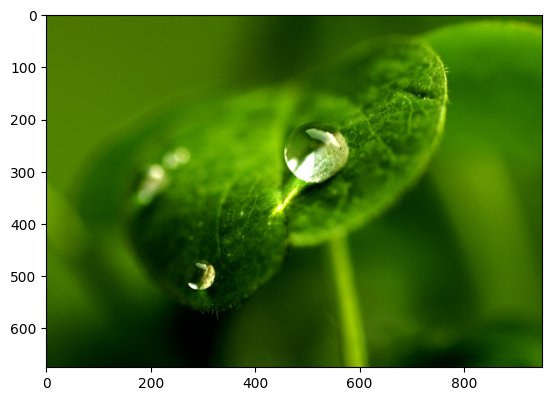

In [21]:
class_names[np.argmax(make_predictions("dataset/dew/2208.jpg"))]

1/1 [==============================] - 0s 134ms/step


'hail'

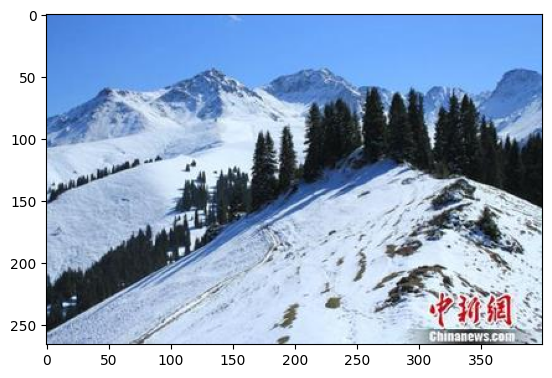

In [22]:
class_names[np.argmax(make_predictions("dataset/snow/0832.jpg"))]

In [23]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [24]:
root_path = 'dataset'
class_dis = [len(os.listdir( root_path+ "/" + name)) for name in class_names]

In [25]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

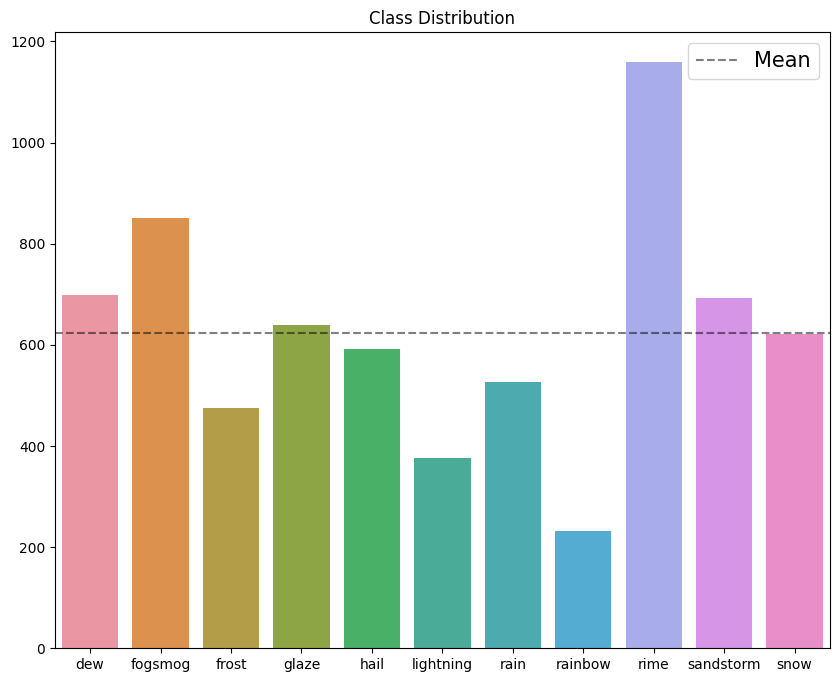

In [26]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dis
)
plt.axhline(np.mean(class_dis), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

In [27]:
from tensorflow.keras.applications import ResNet152V2
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
from keras.preprocessing.image import ImageDataGenerator as IDG

In [29]:
train_gen = IDG(rescale=1./255, horizontal_flip=True, rotation_range=20, validation_split=0.2)

train_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='training', shuffle=True, batch_size=32)
valid_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='validation', shuffle=True, batch_size=32)

Found 5494 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [30]:
name = 'resnet'

base_model = ResNet152V2(include_top=False, input_shape=(256,256,3))
base_model.trainable = False


model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


cbs = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

In [31]:
model.fit(train_ds, callbacks=cbs, validation_data=valid_ds)

172/172 [==============================] - 769s 4s/step - loss: 0.9471 - accuracy: 0.6931 - val_loss: 0.5012 - val_accuracy: 0.8335


In [32]:
model = load_model('resnet.h5')

In [33]:
model.evaluate(valid_ds)

43/43 [==============================] - 131s 3s/step - loss: 0.4952 - accuracy: 0.8313


[0.49523118138313293, 0.8312637209892273]

In [65]:
data_dir = 'dataset/'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [66]:
df

filepaths labels
0      dataset/dew\2208.jpg    dew
1      dataset/dew\2209.jpg    dew
2      dataset/dew\2210.jpg    dew
3      dataset/dew\2211.jpg    dew
4      dataset/dew\2212.jpg    dew
...                     ...    ...
6858  dataset/snow\1446.jpg   snow
6859  dataset/snow\1447.jpg   snow
6860  dataset/snow\1448.jpg   snow
6861  dataset/snow\1449.jpg   snow
6862  dataset/snow\1450.jpg   snow

[6863 rows x 2 columns]

In [67]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [68]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 5490 validated image filenames belonging to 11 classes.
Found 823 validated image filenames belonging to 11 classes.
Found 550 validated image filenames belonging to 11 classes.


In [69]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense_7 (Dense)             (None, 256)               393472    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 11)                2827      
                                                                 
Total params: 11,185,978
Trainable params: 11,095,603
N

In [73]:
epochs = 5   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/5
86/86 [==============================] - 923s 11s/step - loss: 4.4890 - accuracy: 0.9293 - val_loss: 3.8830 - val_accuracy: 0.9125
Epoch 2/5
86/86 [==============================] - 917s 11s/step - loss: 3.2691 - accuracy: 0.9616 - val_loss: 2.8635 - val_accuracy: 0.9283
Epoch 3/5
86/86 [==============================] - 922s 11s/step - loss: 2.3874 - accuracy: 0.9747 - val_loss: 2.1507 - val_accuracy: 0.9210
Epoch 4/5
86/86 [==============================] - 925s 11s/step - loss: 1.7399 - accuracy: 0.9858 - val_loss: 1.6504 - val_accuracy: 0.9186
Epoch 5/5
86/86 [==============================] - 926s 11s/step - loss: 1.2784 - accuracy: 0.9923 - val_loss: 1.2472 - val_accuracy: 0.9283


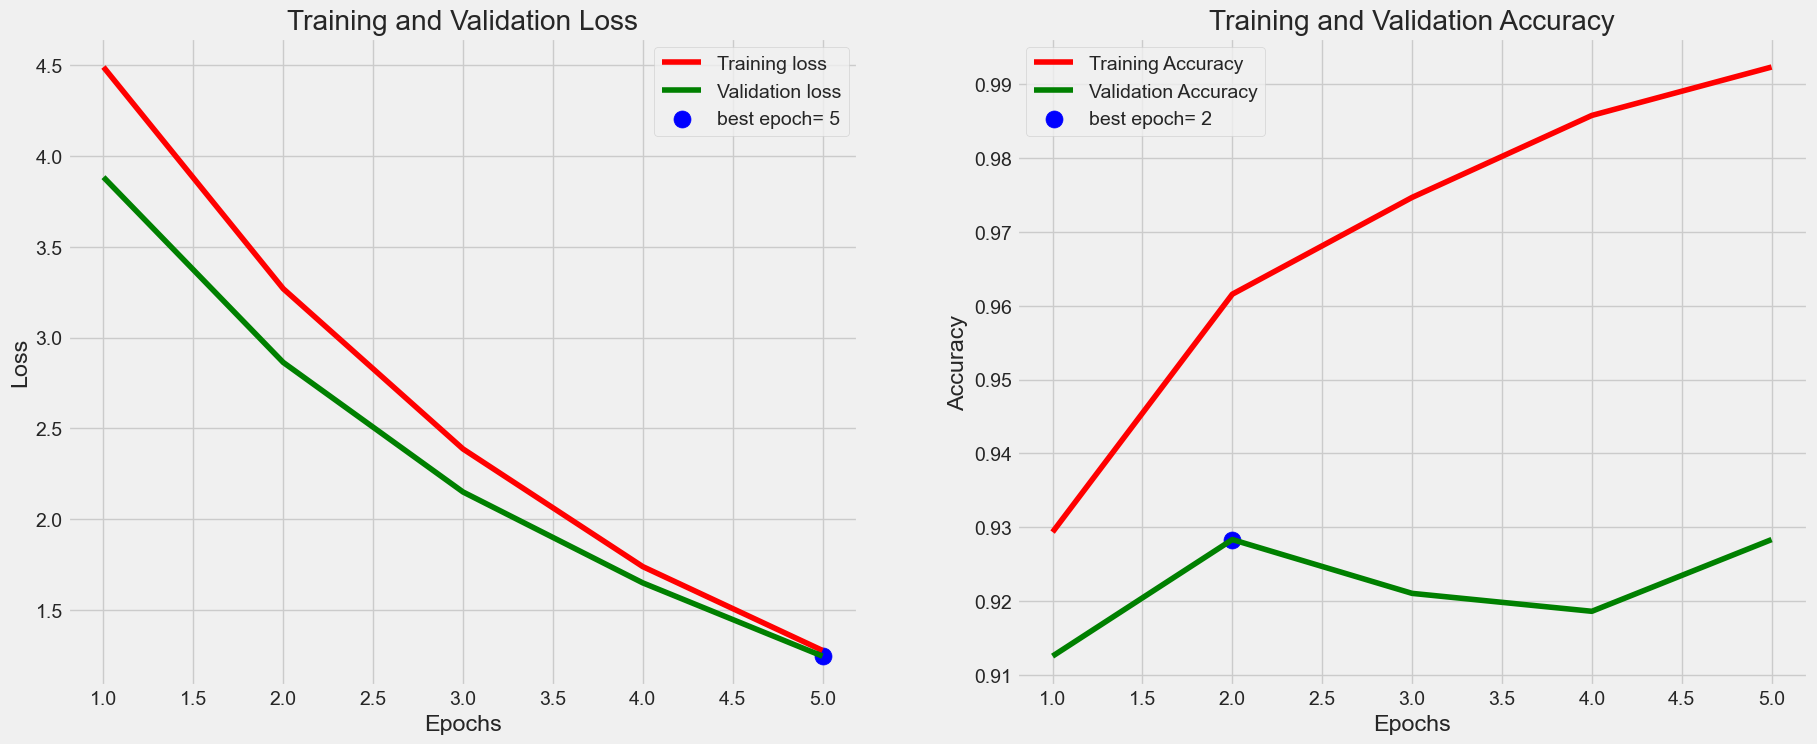

In [74]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [75]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 21s 2s/step - loss: 1.2700 - accuracy: 0.9218
Train Loss:  1.024901032447815
Train Accuracy:  1.0
--------------------
Validation Loss:  1.2316539287567139
Validation Accuracy:  0.9296875
--------------------
Test Loss:  1.270043134689331
Test Accuracy:  0.921818196773529


In [76]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

NameError: name 'itertools' is not defined

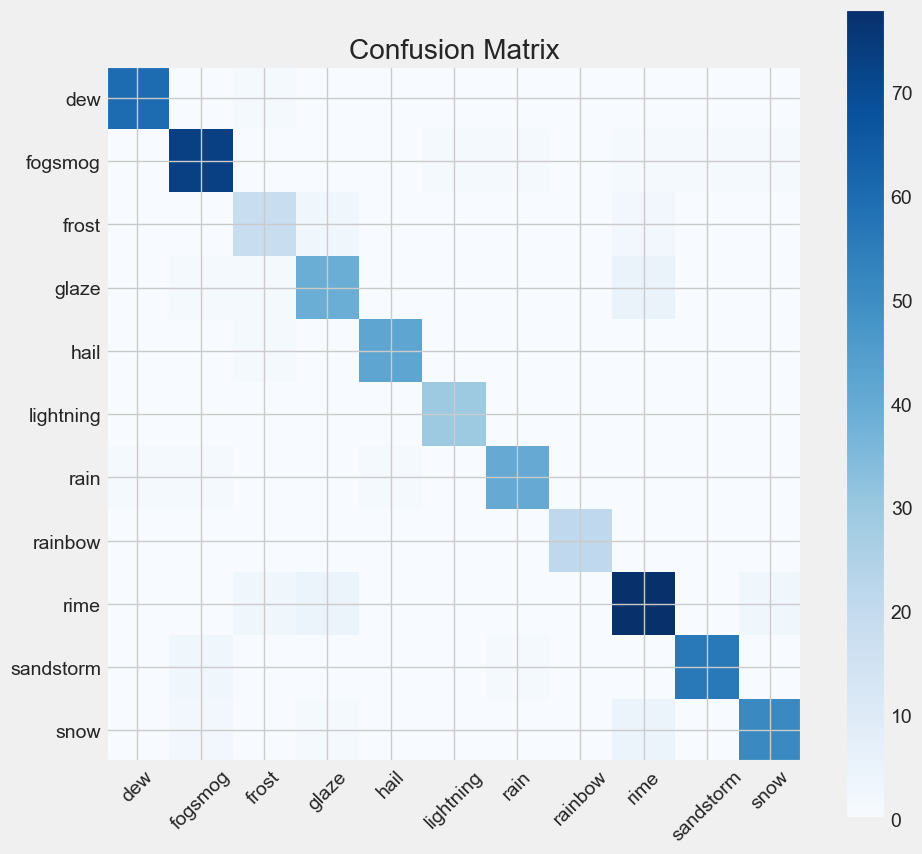

In [77]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()